In [ ]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

## 1- Método para estimación de datos faltantes

In [ ]:
data = pd.read_csv("./dataset.csv", header=0)


MISSING_VALUE = 999.99


def estimate_missing_values(data, k):

    # Separamos los datos en dos conjuntos:
    # - Completos: los datos que no tienen valores en MISSING_VALUE
    complete_df = data
    complete_df = complete_df[~complete_df.isin([MISSING_VALUE]).any(axis=1)]

    # - Incompletos: los datos que tienen al menos 1 valor en MISSING_VALUE
    incomplete_df = data
    incomplete_df = incomplete_df[incomplete_df.isin(
        [MISSING_VALUE]).any(axis=1)]

    # Estandarizamos ambos conjuntos
    scaler = StandardScaler()
    std_complete_df = pd.DataFrame(scaler.fit_transform(complete_df),columns = complete_df.columns)
    std_incomplete_df = pd.DataFrame(scaler.fit_transform(incomplete_df),columns = incomplete_df.columns)

    estimated_data = data.copy()      

    # Calculamos la distancia euclidea entre cada dato incompleto y todos los datos completos
    for i in range(len(incomplete_df)):
        incomplete_row_df = incomplete_df.iloc[[i]]
        std_incomplete_row = std_incomplete_df.iloc[[i]]
        
        missing_column_names = incomplete_row_df.columns[(incomplete_row_df == MISSING_VALUE).iloc[0]] 

        # Eliminamos los datos faltantes
        std_incomplete_row = std_incomplete_row.drop(missing_column_names, axis=1)

            # Eliminamos los datos faltantes
        std_complete_aux = std_complete_df.drop(missing_column_names, axis=1)
        distances = []
        for j in range(len(std_complete_aux)):
            # Almacenamos distancia para ordenamiento e índice de fila 
            distances.append((np.linalg.norm(std_incomplete_row - std_complete_aux.iloc[[j]]), j))

        # Calculamos los k vecinos más cercanos
        k_nearest_neighbors_indexes = map(lambda x: x[1], sorted(
            distances, key=lambda distance: distance[0])[:k])

        # Nos quedamos con los datos de los k vecinos más cercanos
        k_nearest_neighbors_df = complete_df.filter(
            items=k_nearest_neighbors_indexes, axis=0)

        # Calculamos la media de los k vecinos más cercanos para cada dato incompleto
        for missing_column_name in missing_column_names:
            estimated_data.at[incomplete_row_df.index[0], missing_column_name] = k_nearest_neighbors_df[missing_column_name].mean()
    
    return estimated_data

## 2- Comparación de datos sin estandarizar vs estandarizados mediante boxplots

In [40]:
raw_data = data.drop("Sexo", axis=1)

trimmed_data = data[~data.isin([MISSING_VALUE]).any(axis=1)]
trimmed_data = trimmed_data.drop("Sexo", axis=1)

data.loc[data["Sexo"] == "F", "Sexo"] = 1
data.loc[data["Sexo"] == "M", "Sexo"] = -1

estimated = estimate_missing_values(data, k=5)

estimated_data = estimated.drop("Sexo", axis=1)

### 2.1- Comparación de estimadores

In [41]:
print("DATOS SIN MODIFICAR")
display(raw_data.describe());

print("ELIMINANDO DATOS FALTANTES")
display(trimmed_data.describe());

print("RELLENANDO DATOS FALTANTES CON ESTIMACIÓN")
display(estimated_data.describe());

DATOS SIN MODIFICAR


,Grasas_sat,Alcohol,Calorías
count,173.000000,173.000000,173.000000
mean,30.411387,26.019711,1584.554913
std,74.429954,130.079593,305.080991
min,11.820000,0.000000,800.000000
25%,20.200000,1.840000,1400.000000
50%,24.160000,5.970000,1585.000000
75%,28.260000,13.620000,1761.000000
max,999.990000,999.990000,2376.000000


ELIMINANDO DATOS FALTANTES


,Grasas_sat,Alcohol,Calorías
count,169.000000,169.000000,169.000000
mean,24.596331,8.660000,1585.443787
std,6.405481,8.942674,291.439242
min,11.820000,0.000000,900.000000
25%,20.070000,1.760000,1402.000000
50%,24.090000,5.840000,1585.000000
75%,28.020000,12.950000,1757.000000
max,46.360000,40.110000,2376.000000


RELLENANDO DATOS FALTANTES CON ESTIMACIÓN


,Grasas_sat,Alcohol,Calorías
count,173.000000,173.000000,173.000000
mean,24.715191,8.682243,1584.554913
std,6.561154,9.183215,305.080991
min,11.820000,0.000000,800.000000
25%,20.070000,1.580000,1400.000000
50%,24.100000,5.390000,1585.000000
75%,28.040000,12.950000,1761.000000
max,46.360000,40.110000,2376.000000


### 2.2- Comparación de datos no estandarizados vs estandarizados

In [ ]:
# *********************************************************************************************
# * Sin modificar datos
# *********************************************************************************************
# Plot de datos sin estandarizar
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].boxplot(raw_data)
axes[0].set_xticks([1, 2, 3], raw_data.columns)
axes[0].set_title("Boxplot de datos sin estandarizar")

# Plot de datos estandarizados
scaler = StandardScaler().fit(raw_data)
std_raw_data = pd.DataFrame(scaler.transform(raw_data), columns=raw_data.columns)
axes[1].boxplot(std_raw_data)
axes[1].set_xticks([1, 2, 3], raw_data.columns)
axes[1].set_title("Boxplot de datos estandarizados")


# *********************************************************************************************
# * Eliminando datos faltantes
# *********************************************************************************************

# Plot de datos sin estandarizar
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].boxplot(trimmed_data)
axes[0].set_xticks([1, 2, 3], trimmed_data.columns)
axes[0].set_title("Boxplot de datos sin estandarizar\n (Eliminando datos faltantes)")


# Plot de datos estandarizados
scaler = StandardScaler().fit(trimmed_data)
scaled_data = scaler.transform(trimmed_data)
axes[1].boxplot(pd.DataFrame(scaled_data))
axes[1].set_xticks([1, 2, 3], trimmed_data.columns)
axes[1].set_title("Boxplot de datos estandarizados\n (Eliminando datos faltantes)")

# *********************************************************************************************
# * Rellenando los datos faltantes con la media de los datos de los k vecinos más cercanos
# *********************************************************************************************

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].boxplot(estimated_data)
axes[0].set_xticks([1, 2, 3], estimated_data.columns)
axes[0].set_title("Boxplot de datos sin estandarizar\n (Rellenos con estimación)")


scaler = StandardScaler().fit(estimated_data)
scaled_data = scaler.transform(estimated_data)
# Plot de data escalada
axes[1].boxplot(pd.DataFrame(scaled_data))
axes[1].set_xticks([1, 2, 3], estimated_data.columns)
axes[1].set_title("Boxplot de datos estandarizados\n (Rellenos con estimación)")



### 2.3- Análisis de variables

DATOS SIN MODIFICAR


,Grasas_sat,Alcohol,Calorías
count,173.000000,173.000000,173.000000
mean,30.411387,26.019711,1584.554913
std,74.429954,130.079593,305.080991
min,11.820000,0.000000,800.000000
25%,20.200000,1.840000,1400.000000
50%,24.160000,5.970000,1585.000000
75%,28.260000,13.620000,1761.000000
max,999.990000,999.990000,2376.000000


ELIMINANDO DATOS FALTANTES


,Grasas_sat,Alcohol,Calorías
count,169.000000,169.000000,169.000000
mean,24.596331,8.660000,1585.443787
std,6.405481,8.942674,291.439242
min,11.820000,0.000000,900.000000
25%,20.070000,1.760000,1402.000000
50%,24.090000,5.840000,1585.000000
75%,28.020000,12.950000,1757.000000
max,46.360000,40.110000,2376.000000


RELLENANDO DATOS FALTANTES CON ESTIMACIÓN


,Grasas_sat,Alcohol,Calorías
count,173.000000,173.000000,173.000000
mean,24.715191,8.682243,1584.554913
std,6.561154,9.183215,305.080991
min,11.820000,0.000000,800.000000
25%,20.070000,1.580000,1400.000000
50%,24.100000,5.390000,1585.000000
75%,28.040000,12.950000,1761.000000
max,46.360000,40.110000,2376.000000


Text(0.5, 1.0, 'Grasas_sat')

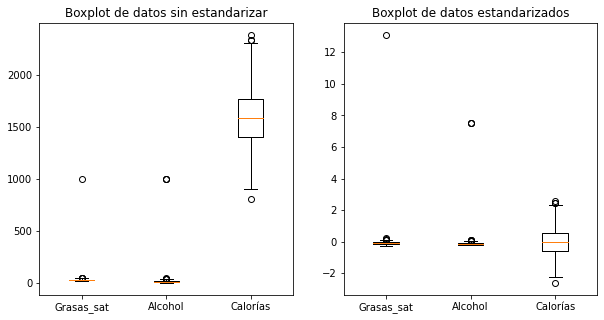

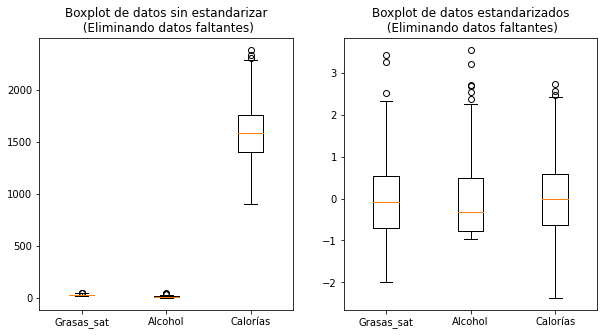

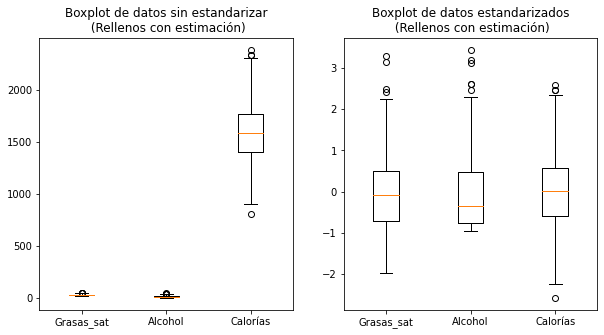

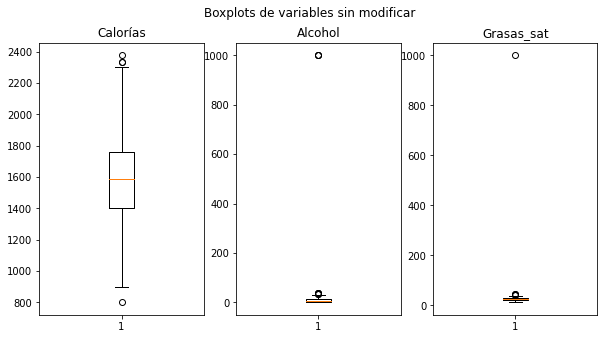

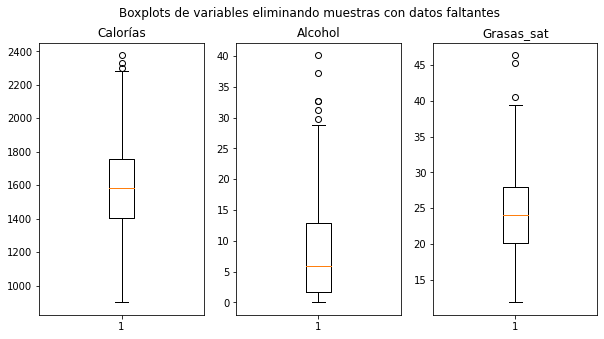

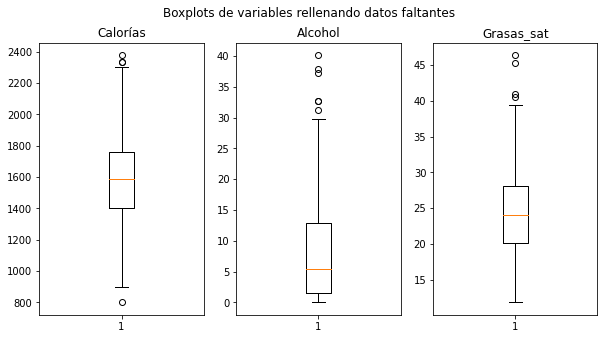

In [38]:

# *********************************************************************************************
# * Boxplots de cada variable por separado
# *********************************************************************************************

# Boxplots de variables sin modificar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
fig.suptitle("Boxplots de variables sin modificar")

axes[0].boxplot(raw_data["Calorías"])
axes[0].set_title("Calorías")

axes[1].boxplot(raw_data["Alcohol"])
axes[1].set_title("Alcohol")

axes[2].boxplot(raw_data["Grasas_sat"])
axes[2].set_title("Grasas_sat")

# Boxplots de variables eliminando muestras con datos faltantes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
fig.suptitle("Boxplots de variables eliminando muestras con datos faltantes")

axes[0].boxplot(trimmed_data["Calorías"])
axes[0].set_title("Calorías")

axes[1].boxplot(trimmed_data["Alcohol"])
axes[1].set_title("Alcohol")

axes[2].boxplot(trimmed_data["Grasas_sat"])
axes[2].set_title("Grasas_sat")

# Boxplots de variables rellenando datos faltantes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
fig.suptitle("Boxplots de variables rellenando datos faltantes")

axes[0].boxplot(estimated_data["Calorías"])
axes[0].set_title("Calorías")

axes[1].boxplot(estimated_data["Alcohol"])
axes[1].set_title("Alcohol")

axes[2].boxplot(estimated_data["Grasas_sat"])
axes[2].set_title("Grasas_sat")

## 4- Análisis de la variable Alcohol en base a las Calorías por categorías

In [ ]:
data = pd.read_csv("./dataset.csv", header=0)
data.loc[data["Sexo"] == "F", "Sexo"] = 1
data.loc[data["Sexo"] == "M", "Sexo"] = -1
estimated_data = estimate_missing_values(data, k=5)

calories_classification = estimated_data.copy()

CALORIES_CATEGORY = [{
    "floor": 0,
    "ceiling": 1100,
},
    {
    "floor": 1100,
    "ceiling": 1700,
},
    {
    "floor": 1700,
    "ceiling": -1,
}]

# Pisamos los datos de calorías con las cotas inferiores de las categorías
# Esto se realiza para aplicar ténicas de agrupación por categoría
for calories_category in CALORIES_CATEGORY[:-1]:
    calories_classification.loc[(calories_classification["Calorías"] >= calories_category["floor"]) & (
        calories_classification["Calorías"] < calories_category["ceiling"]), 'Calorías'] = calories_category["floor"]

calories_classification.loc[calories_classification["Calorías"] >=
                           CALORIES_CATEGORY[-1]["floor"], 'Calorías'] = CALORIES_CATEGORY[-1]["floor"]


# Nos quedamos solo con las columnas de interés
df_alcohol = calories_classification.loc[:, ["Calorías", "Alcohol"]]
# Agrupamos por categoría de calorías
df_calories_groupby = df_alcohol.groupby("Calorías", axis=0)

# Armamos clasificación de alcohol por cada categoría
alcohol_classification = []
labels = []
for calories_group in df_calories_groupby.groups.keys():
    alcohol_classification.append(df_calories_groupby.get_group(
        calories_group)['Alcohol'].values)
    labels.append(calories_group)

fig, axes = plt.subplots(figsize=(10, 5))
axes.boxplot(alcohol_classification)
axes.set_xticks(range(1, len(labels) + 1), labels)
axes.set_title("Boxplots Alcohol por categoría de Calorías")

# TODO: maybe add mean to every boxplot?
